In [1]:
import matplotlib
import seaborn

   MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  \
0          10.253329       10.253329           0.486602       -1.701605   
1          11.724911       11.724911           0.145880       -0.145880   
2          10.020498       10.020498           0.845090        0.845090   
3           2.270278        2.270278           1.301055        1.301055   
4           2.041667        2.041667           1.712963        1.712963   

        qed        SPS    MolWt  HeavyAtomMolWt  ExactMolWt  \
0  0.217518  41.062500  457.432         430.216  457.158411   
1  0.811283   9.933333  201.225         190.137  201.078979   
2  0.343706  11.000000  152.237         136.109  152.120115   
3  0.291526  11.636364  278.354         264.242  278.109550   
4  0.448927   8.000000   84.143          80.111   84.003371   

   NumValenceElectrons  ...  fr_sulfide  fr_sulfonamd  fr_sulfone  \
0                  178  ...           0             0           0   
1                   76  ...     

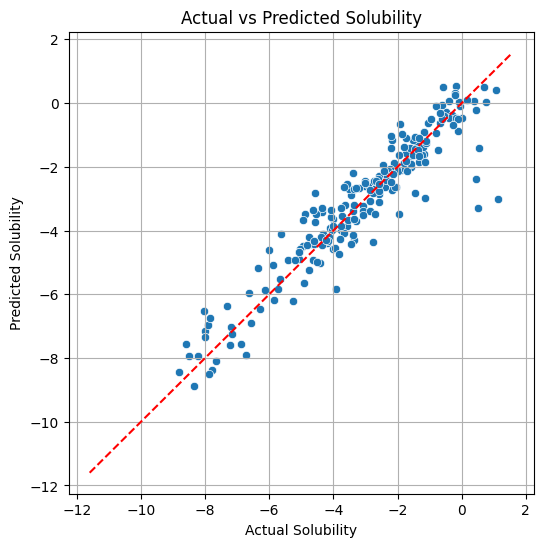

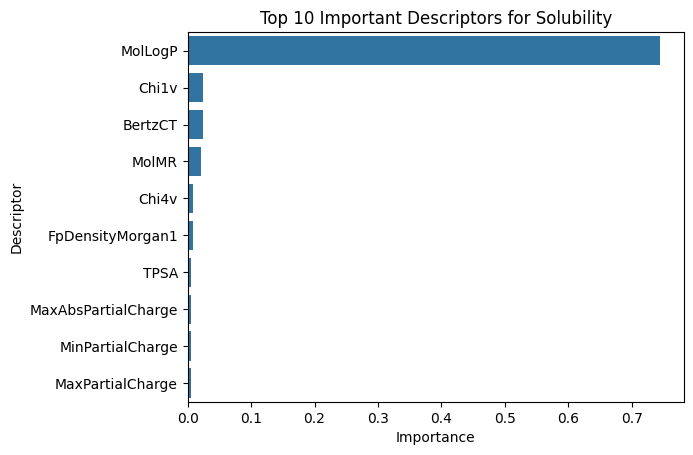

['solubility_predictor.pkl']

In [15]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

# Load dataset
df = pd.read_excel("/Users/boorgupa/Downloads/delaney-processed.xlsx")  # Change to your actual file name

# Normalize column names (optional but helpful)
df.columns = df.columns.str.strip().str.lower()

# Use correct column name
smiles_list = df['smiles']

# Define descriptors
descriptor_names = [desc[0] for desc in Descriptors._descList]
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)

# Function to compute descriptors
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return list(calculator.CalcDescriptors(mol))
    else:
        return [None] * len(descriptor_names)

# Compute descriptors
descriptor_values = smiles_list.apply(compute_descriptors)
descriptor_df = pd.DataFrame(descriptor_values.tolist(), columns=descriptor_names)

# Drop invalid molecules (if any)
descriptor_df.dropna(inplace=True)
df = df.loc[descriptor_df.index].reset_index(drop=True)
descriptor_df = descriptor_df.reset_index(drop=True)

# Show result
print(descriptor_df.head())

# 'descriptor_df' contains your features (217 descriptors)
# 'df' contains the target: measured solubility

X = descriptor_df
y = df['measured log solubility in mols per litre']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.3f}")
print(f"R² Score: {r2:.3f}")

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Solubility")
plt.ylabel("Predicted Solubility")
plt.title("Actual vs Predicted Solubility")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Diagonal line
plt.grid()
plt.show()

import numpy as np

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

top_n = 10
top_features = [X.columns[i] for i in indices[:top_n]]
top_importances = importances[indices[:top_n]]

sns.barplot(x=top_importances, y=top_features)
plt.title("Top 10 Important Descriptors for Solubility")
plt.xlabel("Importance")
plt.ylabel("Descriptor")
plt.show()

import joblib
joblib.dump(model, "solubility_predictor.pkl")




